In [39]:
import tdt
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tkinter import Tk
from tkinter import filedialog
from readSGLX import readMeta, SampRate, makeMemMapRaw, ExtractDigital
from sklearn.linear_model import LinearRegression
from scipy.io import savemat
from warnings import warn

In [40]:
def plot_pulses(onset_times, offset_times, nPulsesToPlot=100):
    '''Use onset and offset times to plot pulse waveforms. 
    Times should be in seconds. Plot only the first N pulses (default 100)'''
    
    #Interleave onset and offset times
    edge_times = np.empty((onset_times.size + offset_times.size,), dtype=onset_times.dtype)
    edge_times[0::2] = onset_times
    edge_times[1::2] = offset_times
    
    # Figure out when pulses are high and when they are low
    sync_levels = np.empty((onset_times.size + offset_times.size,), dtype=onset_times.dtype)
    sync_levels[0::2] = 1
    sync_levels[1::2] = 0

    plt.figure(num=None, figsize=(30, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.step(edge_times[:nPulsesToPlot], sync_levels[:nPulsesToPlot], where='post')

# Load SGLX

In [41]:
def select_sglx_file():
    '''Select a SGLX binary file to extract the digtial sync bit from. 
    Using the LFP file is faster, but the AP file is maximally precise.'''

    
    # Get file from user
    root = Tk()         # create the Tkinter widget
    root.withdraw()     # hide the Tkinter root window

    # Windows specific; forces the window to appear in front
    root.attributes("-topmost", True)

    fullPath = Path(filedialog.askopenfilename(title="Select SpikeGLX binary file"))

    root.destroy()
    
    return fullPath

In [42]:
def sglx_load_sync(sglx_file):
    '''Load the sync channel from the specified binary file. 
    The SpikeGLX metadata file must be present in the same directory as the binary file.'''
    meta = readMeta(sglx_file)
    rawData = makeMemMapRaw(sglx_file, meta)

    # Read the entire file
    firstSamp = 0
    lastSamp = rawData.shape[1]-1

    # Which digital word to read. 
    # For imec, there is only 1 digital word, dw = 0.
    # For NI, digital lines 0-15 are in word 0, lines 16-31 are in word 1, etc.
    dw = 0    
    # Which lines within the digital word, zero-based
    # Note that the SYNC line for PXI 3B is stored in line 6.
    dLineList = [6]
        
    return ExtractDigital(rawData, firstSamp, lastSamp, dw, dLineList, meta)

In [43]:
def sglx_onset_samples(sync):
    '''Extract the pulse rising edge samples from the SGLX sync channel.'''
    # Onsets are the first samples where a value is high after being low. If sample 0 is high, the first onset is sample 0. Consistent with TDT convention.
    onset_samples = np.where(np.diff(np.squeeze(sync), prepend=0) == 1)[0]
    assert(onset_samples.dtype == np.dtype('int64')) # Make sure uint8s have been properly casted as int64s
    return onset_samples

In [44]:
def sglx_offset_samples(sync):
    '''Extract the pulse falling edge samples from the SGLX sync channel'''
    # Offsets are the first samples wehre a value is low after being high. If the last sample is high, the last offset is Inf. Consistent with TDT convention.
    offset_samples = np.where(np.diff(np.squeeze(sync), prepend=0) == -1)[0]
    assert(offset_samples.dtype == np.dtype('int64')) # Make sure uint8s have been properly casted as int64s
    if np.squeeze(sync)[-1] == 1:
        offset_samples = np.append(offset_samples, np.Inf)
    return offset_samples

In [45]:
sglx_file = select_sglx_file()
sglx_sync = sglx_load_sync(sglx_file)
sglx_fs = SampRate(readMeta(sglx_file))
# Times are in seconds from the start of the SGLX recording. 
sglx_onset_times = sglx_onset_samples(sglx_sync) / sglx_fs
sglx_offset_times = sglx_offset_samples(sglx_sync) / sglx_fs

nChan: 385, nFileSamp: 7024595


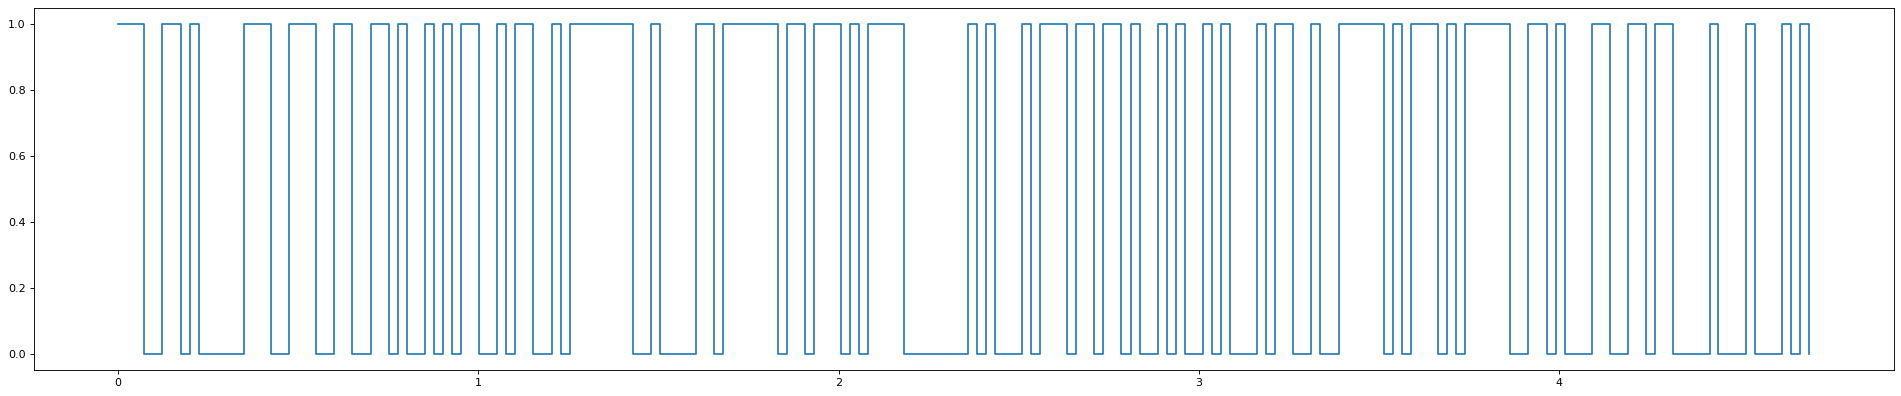

In [46]:
plot_pulses(sglx_onset_times, sglx_offset_times)

# Load TDT

In [47]:
def select_tdt_block():
    '''Select a TDT block to extract sync info from.'''
    # Get file from user
    root = Tk()         # create the Tkinter widget
    root.withdraw()     # hide the Tkinter root window

    # Windows specific; forces the window to appear in front
    root.attributes("-topmost", True)

    fullPath = Path(filedialog.askdirectory(title="Select TDT block"))

    root.destroy()
    
    return fullPath

In [48]:
tdt_file = select_tdt_block()
tdt_data = tdt.read_block(tdt_file, evtype=['epocs'])
# Here, we assume that your digital sync pulse is recorded on Port C0
# YSK: TDT calls the onset of a signal that starts high "0", but the offset of a signal that ends high "inf"
# Times are in seconds from the start of the TDT recording. 
tdt_onset_times = tdt_data.epocs.PC0_.onset 
tdt_offset_times = tdt_data.epocs.PC0_.offset

read from t=0s to t=2808.57s


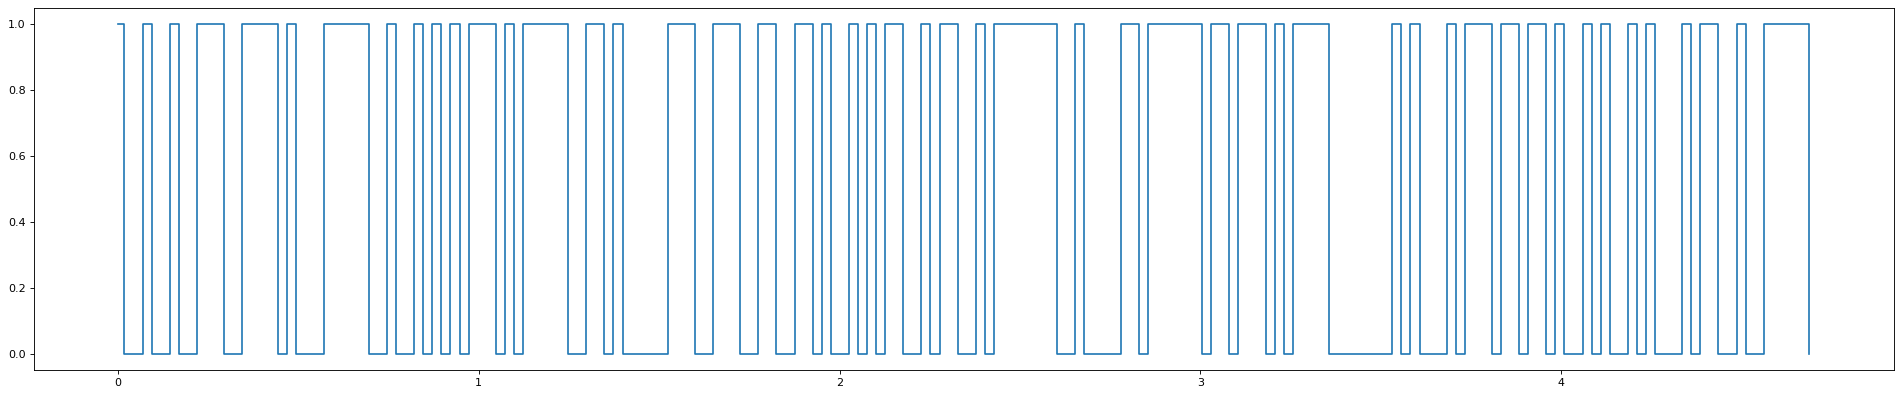

In [49]:
plot_pulses(tdt_onset_times, tdt_offset_times)

# Iteratively shift pulse trains relative to each other and regress

In [50]:
def strip_high_start(onset_times):
    '''Ignore pulses that were already high when the recording started.'''
    return onset_times[np.where(onset_times > 0)]

In [51]:
def equalize_lengths(x, y):
    '''Keep only the first N items in vectors x and y, where N is the size of the smallest vector.
    Makes subsequent computations simpler.'''
    n = np.min([np.size(x), np.size(y)])
    return (x[:n], y[:n])

In [52]:
def preprocess_onset_times(x, y):
    x = strip_high_start(x)
    y = strip_high_start(y)
    return equalize_lengths(x, y)

In [53]:
(sglx_t, tdt_t) = preprocess_onset_times(sglx_onset_times, tdt_onset_times)

In [54]:
def shift(sglx_t, tdt_t, n_pulses, direction):
    '''Remove n_pulses from the start of one signal and the end of the other, then fit the remaining TDT pulses to the remaining SGLX pulses.'''
    
    if direction == 'forward':
        # Remove pulses from the start of the SGLX signal and the end of the TDT signal.
        y = sglx_t[n_pulses:]
        x = tdt_t[:np.size(y)].reshape((-1, 1))
    elif direction == 'backward':
        # Remove pulses from the start of the TDt signal and the end of the SGLX signal.
        x = tdt_t[n_pulses:].reshape((-1, 1))
        y = sglx_t[:np.size(x)]
    else:
        raise("Shift direction must be specified")
    
    model = LinearRegression().fit(x, y)
    r_sq = model.score(x, y)

    return model, r_sq

In [55]:
def eval_shift(sglx_t, tdt_t, n_pulses, direction):
    model, r_sq = shift(sglx_t, tdt_t, n_pulses, direction)
    return r_sq

In [56]:
def _find_mapping(sglx_t, tdt_t, direction, max_shift=None, plot=True):
    '''Iteratively fit signals to each other with different shifts to find the one that maximizes fit.
    max_shift can be used to avoid exhaustively searching all signal offsets. Defaults to 10% of total pulses. 
    If your two systems start recording at very different times, you may need to play with this parameter.
    Reducing it will speed up computation, but also increase change of an error.'''
    if max_shift is None:
        max_shift = np.int(np.ceil(np.min([sglx_t.size, tdt_t.size]) * 0.1)) # Always leaves at least 90% of pulses worth of overlap between the two signals
    
    shifts = np.arange(max_shift) # Generate a list of all the shifts that we are going to try
    
    fits = np.array([eval_shift(sglx_t, tdt_t, n, direction) for n in shifts]) # Evaluate each shift
    
    if plot:
        plt.figure(num=None, figsize=(30, 6), dpi=80, facecolor='w', edgecolor='k')
        plt.plot(shifts, fits)
    
    best_shift = shifts[np.argmax(fits)]  
    model, r_sq = shift(sglx_t, tdt_t, best_shift, direction)
    
    print(direction)
    print('number of pulses shifted:', best_shift)
    print('coefficient of determination:', r_sq)
    print('intercept:', model.intercept_)
    print('drift rate in msec/hr:', (model.coef_[0] - 1)*60*60*1000)
    print(' ')
    
    return model, r_sq

In [57]:
def find_mapping(sglx_t, tdt_t, max_shift=None, plot=True):
    '''Apply _find_mapping twice, sliding the signals past each other in both forward and reverse directions to find the best fit.'''
    
    model_f, r_sq_f = _find_mapping(sglx_t, tdt_t, 'forward', max_shift=max_shift, plot=plot)
    model_b, r_sq_b = _find_mapping(sglx_t, tdt_t, 'backward', max_shift=max_shift, plot=plot)
    
    if r_sq_f > r_sq_b:
        print('TDT times lead SGLX times -- Forward shift selected')
        return model_f
    elif r_sq_b > r_sq_f:
        print('TDT times lag SGLX times -- Backward shift selected')
        return model_b
    else:
        warn("Unexpected: Backward and forward fits are equivalent. Are signals already very close to aligned?")
        assert model_f.intercept_ == model_b.intercept_, "Forward and backward fits have different intercepts."
        assert model_f.coef_[0] == model_b.coef_[0], "Forward and backward fits have different slopes."
        return model_f

forward
number of pulses shifted: 0
coefficient of determination: 0.9999999498546794
intercept: 0.14900316187890894
drift rate in msec/hr: -80.71411619350322
 
backward
number of pulses shifted: 13
coefficient of determination: 0.9999999999999767
intercept: -1.174712015967316
drift rate in msec/hr: -26.174732623740482
 
TDT times lag SGLX times -- Backward shift selected


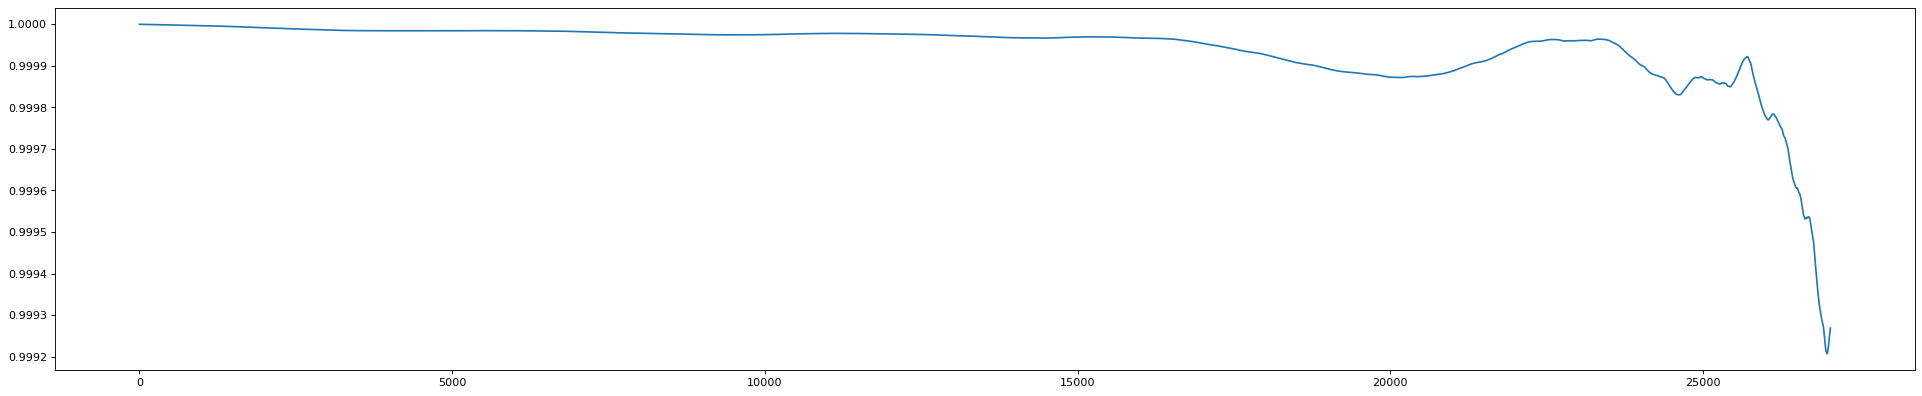

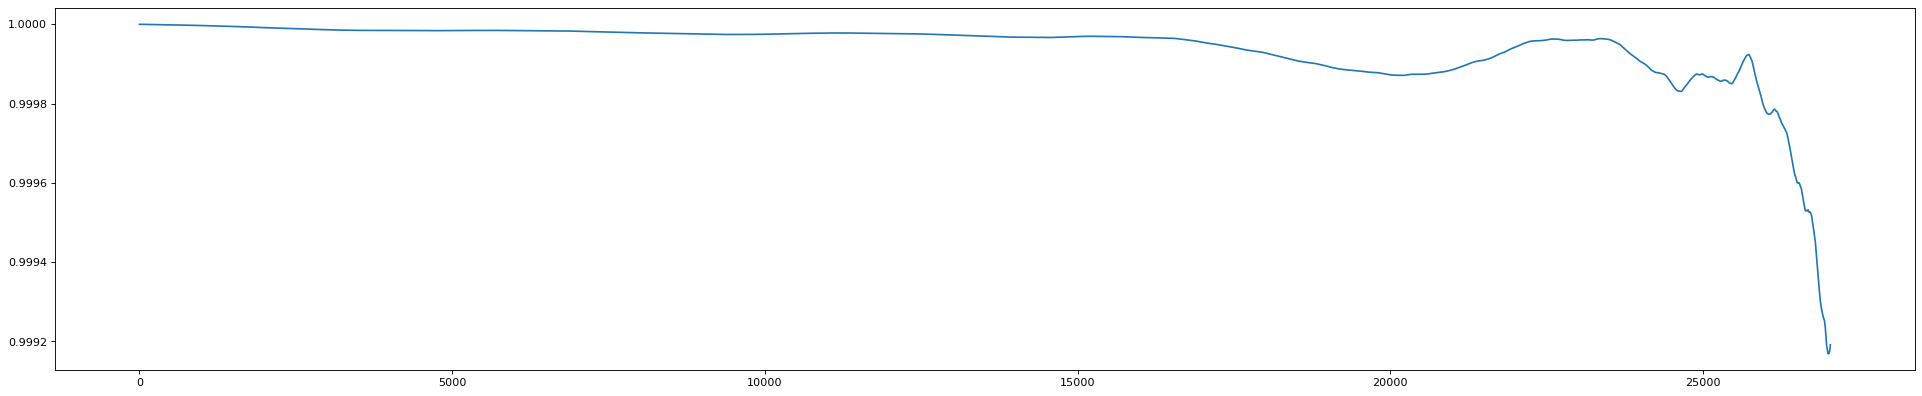

In [58]:
model = find_mapping(sglx_t, tdt_t)

In [59]:
def visualize_mapping(sglx_onset_times, tdt_onset_times, model, nPulsesToPlot=100):
    '''Visualize remapped TDT sync pulse times in SGLX time space, to verify correctness.
    Black lines = Pulse times measured by SGLX.
    Red lines = Pulse times measured by TDT and remapped to SGLX time space. '''
    remapped_tdt_times = model.predict(tdt_t.reshape((-1, 1)))
    
    plt.figure(num=None, figsize=(30, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.vlines(sglx_onset_times[:nPulsesToPlot], 0, 1, colors='black')
    plt.vlines(remapped_tdt_times[:nPulsesToPlot], 0, 1, linestyle='dotted', colors='red')

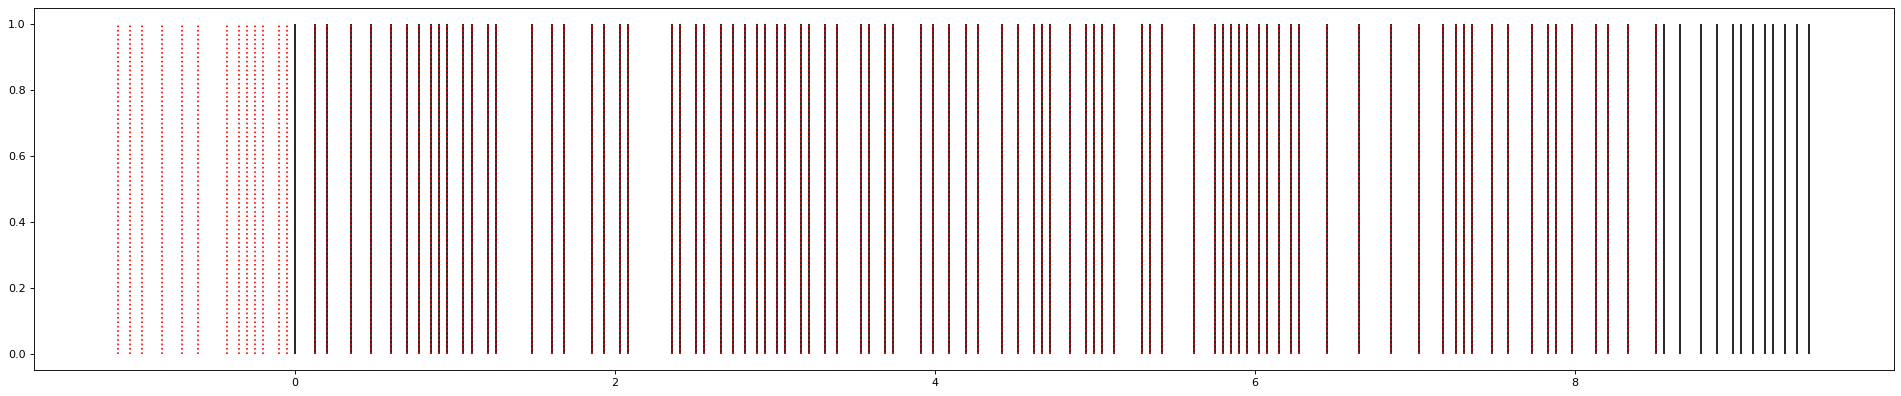

In [60]:
visualize_mapping(sglx_onset_times, tdt_onset_times, model)

# Get TDT stimulation times

In [61]:
def get_stim_times(tdt_data):
    '''Extract the time of each stimulation from a loaded TDT block.
    Times are in seconds from the start of the TDT recording.'''
    CntA = tdt_data.epocs.CntA 
    PeA_ = tdt_data.epocs.PeA_
    
    n_strobes = np.size(PeA_.onset) 
    stim_t = np.array([])
    
    for strobe in np.arange(n_strobes):
        strobe_ISI = PeA_.data[strobe] / 1000 # Convert from msec to sec
        n_strobe_stims = CntA.data[strobe] # The number of stimlations in this strobe
        strobe_start = PeA_.onset[strobe] # The time that this strobe started
        strobe_stims = strobe_start + np.arange(n_strobe_stims) * strobe_ISI # The time of each stimulation in this strobe
        stim_t = np.append(stim_t, strobe_stims)
        
    return stim_t  

In [62]:
def get_stim_samples(tdt_data):
    '''Get the sample numbers of each stimulation, based on epoc store estimates.'''
    eS1r = tdt_data.streams.eS1r
    stim_times = get_stim_times(tdt_data)
    return np.rint(stim_times * eS1r.fs).astype('int')

In [63]:
tdt_data = tdt.read_block(tdt_file, evtype=['epocs', 'streams'])
stim_times = get_stim_times(tdt_data)

read from t=0s to t=2808.57s


In [64]:
def visualize_stims(tdt_data, first_stim=0, last_stim=4, before=100, after=100, ch=8):
    '''Visualize estimated stimulation times (block dotted lines) relative to the stimulator current stream.
    first_stim is the 0-based index of the first stimulation to plot.
    last_stim is the 0-based index of the last stimulation to plot. 
    before/after are the number of samples to plot before the first stim and after the last stim.
    ch is the stimulator current channel to plot.'''
    stim_samples = get_stim_samples(tdt_data)
    samplesToPlot = np.arange(stim_samples[first_stim] - before, stim_samples[last_stim] + after)

    plt.figure(num=None, figsize=(30, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.plot(samplesToPlot, tdt_data.streams.eS1r.data[ch, samplesToPlot])
    plt.vlines(stim_samples[first_stim : last_stim + 1], 0, 1000, linestyle='dotted', colors='black')

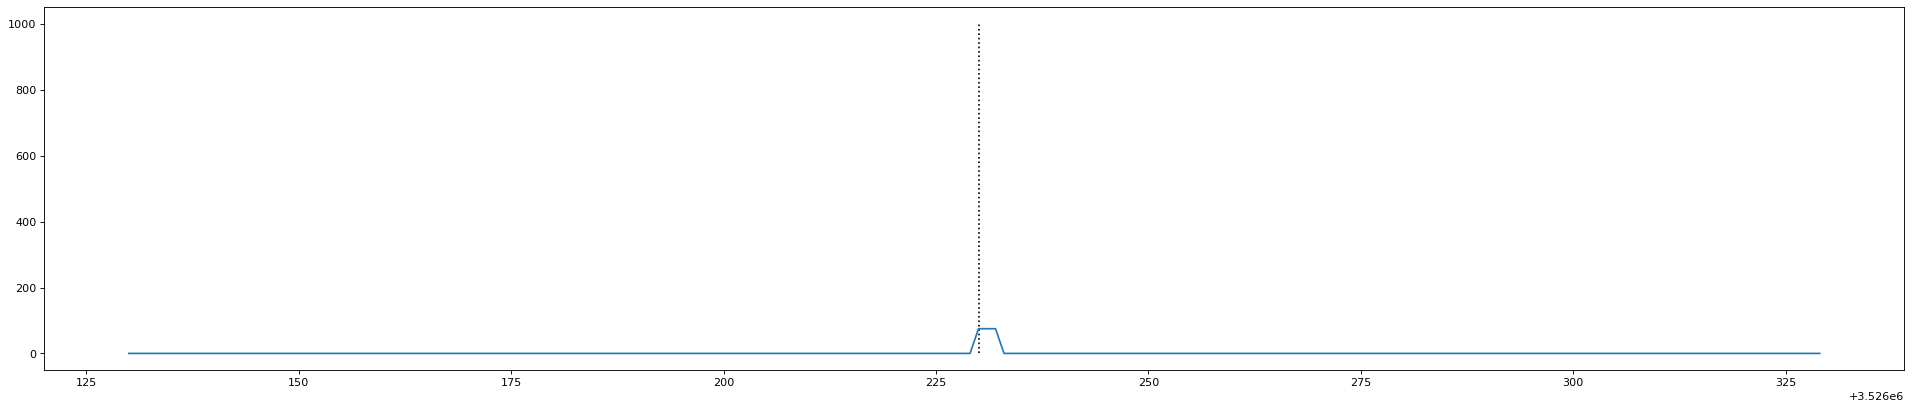

In [65]:
visualize_stims(tdt_data, first_stim=10, last_stim=10)

In [66]:
# Remap the stimulation times from TDT time space to SGLX time space, based on sync signal offset and drift between the two systems. 
sglx_stim_times = model.predict(stim_times.reshape((-1, 1)))
sglx_stim_times

array([ 375.45732716,  379.45728758,  383.457248  ,  387.45720842,
        391.45716884,  415.6265071 ,  419.62646752,  423.62642794,
        427.62638836,  431.62634878,  576.55856963,  580.55853005,
        584.55849047,  588.55845089,  592.55841131,  596.55837173,
        600.55833215,  604.55829257,  608.55825299,  612.5582134 ,
        635.43900169,  639.4389621 ,  643.43892252,  647.43888294,
        651.43884336,  655.43880378,  659.4387642 ,  663.43872462,
        667.43868504,  671.43864546,  780.01851751,  784.01847793,
        788.01843835,  792.01839877,  796.01835919,  800.01831961,
        804.01828003,  808.01824045,  812.01820087,  816.01816129,
        890.93304932,  894.93300974,  898.93297015,  902.93293057,
        906.93289099,  910.93285141,  914.93281183,  918.93277225,
        922.93273267,  926.93269309, 1026.33656786, 1030.33652828,
       1034.3364887 , 1038.33644912, 1042.33640954, 1046.33636996,
       1050.33633038, 1054.3362908 , 1058.33625121, 1062.33621

In [67]:
def matlab_saveas_dialog():
    # Get file from user
    root = Tk()         # create the Tkinter widget
    root.withdraw()     # hide the Tkinter root window

    # Windows specific; forces the window to appear in front
    root.attributes("-topmost", True)

    fullPath = Path(filedialog.asksaveasfilename(title="Save as", defaultextension=".mat", filetypes=(("MATLAB", "*.mat"),)))

    root.destroy()
    
    return fullPath

In [ ]:
# Export the results for use in MATLAB. 
# The names of the SGLX and TDT files used are saved with the data. 
matlab_file = matlab_saveas_dialog()
savemat(matlab_file, {'sglx_stim_times': sglx_stim_times, 'sglx_file': sglx_file.name, 'tdt_file': tdt_file.name})